In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import pyro

from src.data.preprocessing import load_thickness_time_series
from src.models.paths import PROJECT_ROOT
from src.models.solid_earth_utils import compute_love_numbers, greens_function

print(PROJECT_ROOT)
pyro.set_rng_seed(42)

/data/eigil/work/premis


In [2]:
class FFNN(torch.nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        super(FFNN, self).__init__()
        
        # Architecture
        self.in_layer = torch.nn.Linear(n_in, n_hidden)
        self.h1_layer = torch.nn.Linear(n_hidden, n_hidden)
        self.h2_layer = torch.nn.Linear(n_hidden, n_hidden)
        self.out_layer = torch.nn.Linear(n_hidden, n_out)
        
        # Activation functions
        self.relu = torch.nn.ReLU()
        
    def forward(self, X):
        # Forward pass
        X = self.relu(self.in_layer(X))
        X = self.relu(self.h1_layer(X))
        X = self.relu(self.h2_layer(X))
        X = self.out_layer(X)
        
        return X

In [3]:
from torch.distributions import constraints
from torch.distributions.transforms import AbsTransform

from pyro.distributions.torch import TransformedDistribution
from torch.distributions.transforms import Transform 

class IntervalTransform(Transform):
    r"""
    Transform via the mapping :math:`y = a <= x <= b`.
    """
    domain = constraints.real
    codomain = constraints.positive
    def __init__(self, a, b, event_dim=0, cache_size=0):
        self.a = a
        self.b = b
        self._event_dim = event_dim
        self._cache_size = cache_size
        
    def __eq__(self, other):
        return isinstance(other, IntervalTransform(self.a, self.b))

    def _call(self, x):
        x[self.a > x] = self.a
        x[self.b < x] = self.b
        return x

    def _inverse(self, y):
        return y

class IntervalFoldedDistribution(TransformedDistribution):
    """
    Equivalent to ``TransformedDistribution(base_dist, AbsTransform())``,
    but additionally supports :meth:`log_prob` .

    :param ~torch.distributions.Distribution base_dist: The distribution to
        reflect.
    """

    support = constraints.positive

    def __init__(self, base_dist, validate_args=None, lower=8e3, upper=1.4e4):
        if base_dist.event_shape:
            raise ValueError("Only univariate distributions can be folded.")
        super().__init__(base_dist, IntervalTransform(a=lower, b=upper), validate_args)

    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(type(self), _instance)
        return super().expand(batch_shape, _instance=new)


    def log_prob(self, value):
        if self._validate_args:
            self._validate_sample(value)
        dim = max(len(self.batch_shape), value.dim())
        plus_minus = value.new_tensor([1.0, -1.0]).reshape((2,) + (1,) * dim)
        return self.base_dist.log_prob(plus_minus * value).logsumexp(0)

In [4]:
from torch.distributions import constraints
from torch.distributions.transforms import AbsTransform

from pyro.distributions.torch import TransformedDistribution
from torch.distributions.transforms import Transform 

class IntervalTransform(Transform):
    r"""
    Transform via the mapping :math:`y = a <= x <= b`.
    """
    domain = constraints.real
    codomain = constraints.positive
    def __init__(self, a, b, event_dim=0, cache_size=0):
        self.a = a
        self.b = b
        self._event_dim = event_dim
        self._cache_size = cache_size
        
    def __eq__(self, other):
        return isinstance(other, IntervalTransform(self.a, self.b))

    def _call(self, x):
        x[self.a > x] = self.a
        x[self.b < x] = self.b
        return x

    def _inverse(self, y):
        return y

class IntervalFoldedDistribution(TransformedDistribution):
    """
    Equivalent to ``TransformedDistribution(base_dist, AbsTransform())``,
    but additionally supports :meth:`log_prob` .

    :param ~torch.distributions.Distribution base_dist: The distribution to
        reflect.
    """

    support = constraints.positive

    def __init__(self, base_dist, validate_args=None, lower=8e3, upper=1.4e4):
        if base_dist.event_shape:
            raise ValueError("Only univariate distributions can be folded.")
        super().__init__(base_dist, IntervalTransform(a=lower, b=upper), validate_args)

    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(type(self), _instance)
        return super().expand(batch_shape, _instance=new)


    def log_prob(self, value):
        if self._validate_args:
            self._validate_sample(value)
        dim = max(len(self.batch_shape), value.dim())
        plus_minus = value.new_tensor([1.0, -1.0]).reshape((2,) + (1,) * dim)
        return self.base_dist.log_prob(plus_minus * value).logsumexp(0)

In [14]:
Nr = np.arange(1, 7).tolist()
radius = [6371e3, 6341e3, 6311e3, 5951e3, 5701e3, 3480e3]
density = [3.037e3, 3.230e3, 3.438e3, 3.871e3, 4.978e3, 10.750e3]
rigidity = [0.50605e11, 0.50605e11, 0.70363e11, 1.05490e11, 2.28340e11, 0.0000e11]
bulk = [5.7437e10, 5.7437e10, 9.9633e10, 1.5352e11, 3.2210e11, 1.1018e12]
viscosity = [1.0e55, 1.0e21, 1.0e21, 1.0e21, 2.0e21, 0.0e21]

df_em = pd.DataFrame(
    np.array([Nr, radius, density, rigidity, bulk, viscosity]).T,
    columns=["Nr", "radius", "density", "rigidity", "bulk", "viscosity"],
)

lmax = 256
lmin = 0
lstep = 1
CONF = {
    "EARTH_FILE": "earth_M3L70V01c.txt",
    "COMPRESS": "1",
    "DEGREE_RANGE": f"{lmin} {lmax} {lstep}",
    "LABEL_OUTPUT": f"Bench_C_{lmax}_{lmin}_{lstep}",
}

df_kuaq = pd.read_csv(PROJECT_ROOT / "data" / "processed" / "KUAQ_filtered.csv")
df_kuaq.Time = pd.to_datetime(df_kuaq.Time)
# df_mass = pd.read_csv(PROJECT_ROOT / "data" / "processed" / "mass_time_series.csv")
df_height = load_thickness_time_series(
    PROJECT_ROOT / "data" / "processed" / "1900_2020_mean_thickness.mat"
)
df = pd.merge(df_height, df_kuaq, how="inner")

height = df.Thickness.values
uplift = df.Up.values

df_em

,Nr,radius,density,rigidity,bulk,viscosity
0,1.0,6371000.0,3037.0,5.060500e+10,5.743700e+10,1.000000e+55
1,2.0,6341000.0,3230.0,5.060500e+10,5.743700e+10,1.000000e+21
2,3.0,6311000.0,3438.0,7.036300e+10,9.963300e+10,1.000000e+21
3,4.0,5951000.0,3871.0,1.054900e+11,1.535200e+11,1.000000e+21
4,5.0,5701000.0,4978.0,2.283400e+11,3.221000e+11,2.000000e+21
5,6.0,3480000.0,10750.0,0.000000e+00,1.101800e+12,0.000000e+00


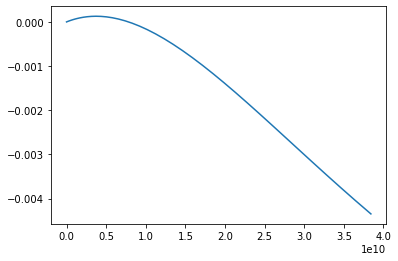

In [6]:
areas = np.arange(1e3, 200e3, 5e3)**2
gf_list = []
for area in areas:
    hlove, nlove = compute_love_numbers(df_em=df_em, CONF=None, verbose=0)
    gf_list.append(greens_function(hlove, nlove, [68.704665, -33.214577], [68.58700000, -33.05270000], arsurf=area))

plt.plot(areas, gf_list)

In [7]:
t = np.arange(len(uplift))
G = np.vstack([t**3, t**2, t, np.ones_like(t)]).T
a, b, c, d = np.linalg.lstsq(G, uplift, rcond=None)[0]
trend = a * t**3 + b * t**2 + c * t + d
a, b, c, d

(0.00013715258698306744,
 -0.03206968059261704,
 3.5151983255279635,
 -132.5784591357166)

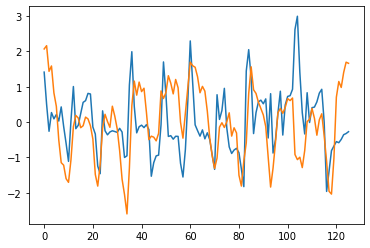

In [8]:
tmp = (height - np.mean(height)) / np.std(height)
tmp2 = uplift - trend
tmp2 = (tmp2 - np.mean(tmp2)) / np.std(tmp2)
plt.plot(5e3 * tmp * gf_list[20])
plt.plot(tmp2)

In [9]:
# X_time = np.concatenate([pd.get_dummies(df[x]) for x in ["dow", "tod"]], axis=1)
# pd.get_dummies(df["Time"])
# Make month columns
df1 = pd.concat([df, df.Time.dt.month], axis=1)
df1.columns = [*df1.columns[:-1], 'Month']
df1.head()

# make one hot encoding of month number
month_number = np.array(pd.get_dummies(df1["Month"]))

In [10]:
standardized_height = (height - np.mean(height) / np.std(height))
X_cat = np.concatenate([standardized_height[np.newaxis].T, month_number], axis=1)
X_train = torch.tensor(X_cat).float()
y_train = torch.tensor(uplift - trend).float()
y_train = (y_train - y_train.mean()) / y_train.std()
len(X_train)

126

In [32]:
df_params = pd.read_csv('../ffnn_variable_normalisation_params.csv')

x = np.hstack(((df_em["radius"].values - df_params["radius_mu"][0]) / df_params["radius_sigma"][0], 
                (df_em["density"].values - df_params["density_mu"][0]) / df_params["density_sigma"][0],
                (df_em["rigidity"].values - df_params["rigidity_mu"][0]) / df_params["rigidity_sigma"][0], 
                (df_em["bulk"].values - df_params["bulk_mu"][0]) / df_params["bulk_sigma"][0], 
                (df_em["viscosity"].values - df_params["viscosity_mu"][0]) / df_params["viscosity_sigma"][0]))
x = np.array(x, dtype=np.float32)
x = np.insert(x, 0, 80)
x = torch.tensor(x, dtype=torch.float32)
x

tensor([ 8.0000e+01,  6.6610e-01,  6.3665e-01,  6.0719e-01,  2.5377e-01,
         8.3446e-03, -2.1721e+00, -7.4027e-01, -6.6708e-01, -5.8821e-01,
        -4.2401e-01, -4.2200e-03,  2.1846e+00, -4.3644e-01, -4.3644e-01,
        -3.0375e-01, -6.7859e-02,  7.5714e-01, -7.7628e-01, -6.5145e-01,
        -6.5145e-01, -5.3749e-01, -3.9196e-01,  6.3319e-02,  2.1690e+00,
         2.2361e+00, -4.4721e-01, -4.4721e-01, -4.4721e-01, -4.4721e-01,
        -4.4721e-01])

In [33]:
ffnn = FFNN(31, 200, 258)  # in shape, n hidden, out shape
ffnn.load_state_dict(torch.load("../ffnn_v0.pt"))
ffnn.eval()

FFNN(
  (in_layer): Linear(in_features=31, out_features=200, bias=True)
  (h1_layer): Linear(in_features=200, out_features=200, bias=True)
  (h2_layer): Linear(in_features=200, out_features=200, bias=True)
  (out_layer): Linear(in_features=200, out_features=258, bias=True)
  (relu): ReLU()
)

In [36]:
def model(X, x, df_params, obs=None, df_em=None):
    N = len(X)
    t = torch.linspace(0, 1, N)

    sigma_w = pyro.sample("sigma", dist.HalfCauchy(1.2 * torch.ones(N)))
    
    # rigidity layer 1
    loc, scale = 2, 0.5
    rigidity_dist_1 = IntervalFoldedDistribution(dist.Normal(loc, scale), lower=loc * 1e-2, upper=loc * 5e1)
    rigidity_1 = 1e11 + 1e10 * pyro.sample("rigidity_1", rigidity_dist_1)

    # rigidity layer 2
    loc, scale = 4, 0.5
    rigidity_dist_2 = IntervalFoldedDistribution(dist.Normal(loc, scale), lower=loc * 1e-2, upper=loc * 5e1)
    rigidity_2 = 1e11 + 1e10 * pyro.sample("rigidity_2", rigidity_dist_2)
    
    x[14] = (rigidity_1 - df_params["rigidity_mu"][0]) / df_params["rigidity_sigma"][0]
    x[15] = (rigidity_1 - df_params["rigidity_mu"][0]) / df_params["rigidity_sigma"][0]

    hlove = ffnn(x).detach().numpy()
    nlove = len(hlove)
    
    # Draw Greens Function
    gf = pyro.deterministic("gf", torch.tensor(greens_function(hlove, nlove, [68.704665, -33.214577], [68.58700000, -33.05270000], arsurf=80e3 * 80e3)))
  
    # Draw target
    with pyro.plate("data"):
        w = pyro.sample("w", dist.Normal(5e3 * gf * X[:, 0], sigma_w), obs=obs)  # 1e5 is a scaling constant
    
    return w

In [40]:
# import os
# os.environ["OMP_NUM_THREADS"] = '1'
# Run inference in Pyro

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=100, num_chains=1)
mcmc.run(X_train, x, df_params, y_train, df_em)

Sample: 100%|██████████| 1100/1100 [02:21,  7.75it/s, step size=1.14e-01, acc. prob=0.899]


In [41]:
# Show summary of inference results
mcmc.summary() # exclude_deterministic=False


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
  rigidity_1      2.04      0.42      2.01      1.32      2.65    979.90      1.00
  rigidity_2      4.02      0.51      4.02      3.08      4.80   1485.23      1.00
    sigma[0]  24502.69  34816.09  16079.11   5305.58  44973.13    363.35      1.00
    sigma[1]   8621.66   7664.99   6344.73   2228.89  15876.31    577.98      1.00
    sigma[2]   1906.22   2397.61   1324.91    428.31   3109.68    355.15      1.00
    sigma[3]   6527.42  12794.45   4024.84   1230.71  10930.15    450.57      1.00
    sigma[4]   3222.00   3472.11   2227.34    739.17   6207.53    704.35      1.00
    sigma[5]   4505.05   3892.90   3316.69   1192.84   8061.38    627.13      1.00
    sigma[6]   2219.17   2363.63   1553.13    520.11   3882.93    459.43      1.01
    sigma[7]   7995.78   9431.43   5468.99   1813.46  13619.76    235.65      1.00
    sigma[8]     69.33     68.78     48.64     17.95    126.71    320.96      1.00
   

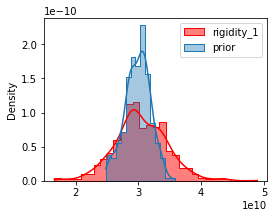

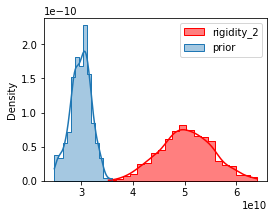

In [42]:
samples = {k: v for k, v in mcmc.get_samples().items()}
nodes = ["rigidity_1", "rigidity_2"]

rigidity_dist_prior = dist.Normal(2 * torch.ones(300), 0.2)
rigidity_prior = 1e10 + 1e10 * pyro.sample("rigidity_prior", rigidity_dist_prior)

for node in nodes:
    plt.figure(figsize=(4,3))
    sns.histplot(1e10 + 1e10 * samples[node], label=node, kde=True, stat='density', element="step", color="red")
    sns.histplot(rigidity_prior, label="prior", kde=True, stat='density', element="step", alpha=0.4)
    plt.legend()
    plt.show()

In [ ]:
df_em

,Nr,radius,density,rigidity,bulk,viscosity
0,1.0,6371000.0,3037.0,1.388549e+11,5.743700e+10,1.000000e+55
1,2.0,6301000.0,3438.0,1.532514e+11,9.963300e+10,1.000000e+21
2,3.0,5951000.0,3871.0,1.054900e+11,1.535200e+11,1.000000e+21
3,4.0,5701000.0,4978.0,2.283400e+11,3.221000e+11,2.000000e+21
4,5.0,3480000.0,10750.0,0.000000e+00,1.101800e+12,0.000000e+00


In [96]:
# saves the model and optimizer states to disk
def save_checkpoint(model):
    log("saving model to %s..." % args.save_model)
    torch.save(dmm.state_dict(), args.save_model)
    log("saving optimizer states to %s..." % args.save_opt)
    optimizer.save(args.save_opt)
    log("done saving model and optimizer checkpoints to disk.")

# loads the model and optimizer states from disk
def load_checkpoint():
    assert exists(args.load_opt) and exists(args.load_model), \
        "--load-model and/or --load-opt misspecified"
    log("loading model from %s..." % args.load_model)
    dmm.load_state_dict(torch.load(args.load_model))
    log("loading optimizer states from %s..." % args.load_opt)
    optimizer.load(args.load_opt)
    log("done loading model and optimizer states.")

dict_keys(['rigidity_1', 'rigidity_2', 'sigma'])

In [26]:
N = len(height)
X = np.arange(N)



In [27]:
rig_list = mcmc.get_samples()["rigidity_1"].detach().numpy()
gf_list = []
for rig in rig_list:
    df_em["rigidity"][0] = rig * 1e10
    hlove, nlove = compute_love_numbers(df_em=df_em, CONF=None, verbose=0)
    gf_list.append(greens_function(hlove, nlove, [68.704665, -33.214577], [68.58700000, -33.05270000]))

In [28]:
gf_arr = np.mean(np.array(gf_list))
alpha_hat = np.mean(mcmc.get_samples()["alpha"].detach().numpy())
beta_hat = np.mean(mcmc.get_samples()["beta"].detach().numpy())
y_hat = alpha_hat + X * beta_hat + gf_arr * height

In [32]:
np.mean(np.array(gf_list))

2.438294287008171e-07

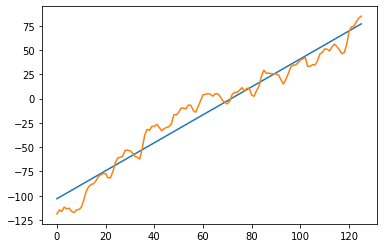

In [33]:
plt.plot(y_hat)
plt.plot(uplift)


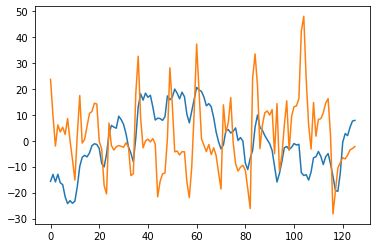

In [48]:
plt.plot((uplift - y_hat))
plt.plot(-0.02 * height + tid * A)

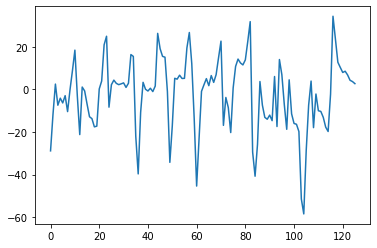

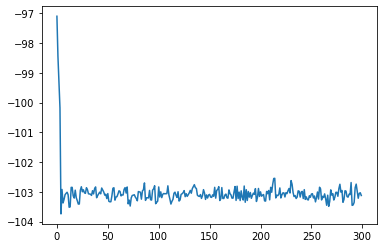

In [49]:
plt.plot(mcmc.get_samples()["alpha"].detach().numpy())

In [ ]:
def model(X, obs=None, df_em=None):
    N = len(X)
    t = torch.linspace(0, 1, N)

    sigma_w = pyro.sample("sigma", dist.HalfCauchy(1.2 * torch.ones(N)))
    
    # rigidity layer 1
    loc, scale = 2, 0.5
    rigidity_dist_1 = IntervalFoldedDistribution(dist.Normal(torch.ones(2) * loc, scale), lower=loc * 1e-2, upper=loc * 5e1)
    rigidity_1 = 1e11 + 1e10 * pyro.sample("rigidity_1", rigidity_dist_1)

    # rigidity layer 2
    # loc, scale = 4, 0.5
    # rigidity_dist_2 = IntervalFoldedDistribution(dist.Normal(loc, scale), lower=loc * 1e-2, upper=loc * 5e1)
    # rigidity_2 = 1e11 + 1e10 * pyro.sample("rigidity_2", rigidity_dist_2)
    
    # dictionary = {"sample": sample1}
    df_em["rigidity"][0] = rigidity_1[0].item()
    df_em["rigidity"][1] = rigidity_1[1].item()

    # Draw Love Numbers
    hlove, nlove = compute_love_numbers(df_em=df_em, CONF=None, verbose=0)
    
    # Draw Greens Function
    gf = pyro.deterministic("gf", torch.tensor(greens_function(hlove, nlove, [68.704665, -33.214577], [68.58700000, -33.05270000], arsurf=80e3 * 80e3)))
  
    # Draw target
    with pyro.plate("data"):
        w = pyro.sample("w", dist.Normal(5e3 * gf * X[:, 0], sigma_w), obs=obs)  # 1e5 is a scaling constant
    
    return w

## Different things from earlier work

In [ ]:
dont run the next cells

In [ ]:
class TruncatedNormal(dist.Rejector):
    def __init__(self, loc, scale_0, max_x0):
        propose = dist.Normal(loc, scale_0)

        def log_prob_accept(x):
            return (x[0] < max_x0).type_as(x).log()

        log_scale = torch.tensor(dist.LogNormal(loc, scale_0).cdf(max_x0)).log()
        super(TruncatedLogNormal, self).__init__(propose, log_prob_accept, log_scale)

In [ ]:
## TODO: For guide support, see: https://forum.pyro.ai/t/truncated-log-normal-distribution/2002
# from torch.distributions import constraints

# class TruncatedLogNormal(dist.Rejector):
#     ...
#     @constraints.dependent_property
#     def support(self):
#         return constraints.interval(0, self.max_x0)

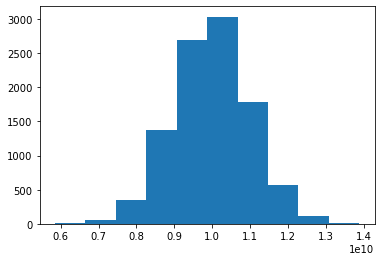

In [ ]:
diste = IntervalFoldedDistribution(dist.Normal(1e10*torch.ones(10000), 1e9), lower=1e8, upper=1e12)
plt.hist(np.array(pyro.sample("test", diste)));

tensor(0.)

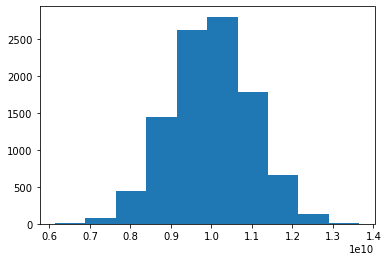

In [ ]:
samples = 1e10 * pyro.sample("test", dist.Normal(torch.ones(10000), 0.1))
plt.hist(np.array(samples));
samples[samples < 1e8].sum()

In [ ]:
import numpyro
import numpyro.distributions as np_dist
from numpyro.infer import MCMC, NUTS

def model():

    # sample1 = numpyro.sample("rigidity1", bounded_rig1)
    rigidity_unscaled = numpyro.sample("rigidity_unscaled", np_dist.Normal(0, 1))
    
    rigidity_scaled = numpyro.deterministic("rigidity_scaled", 1e10 + 1e9 * rigidity_unscaled)
    # rigidity_scaled = numpyro.sample("rigidity_scaled", np_dist.Uniform(1e9, 1e11))

    
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(model)
num_samples = 10000
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples)
mcmc.run(rng_key_)

print(mcmc.get_samples()["rigidity_scaled"].min() , mcmc.get_samples()["rigidity_scaled"].mean(), mcmc.get_samples()["rigidity_scaled"].max())

sample: 100%|██████████| 11000/11000 [00:14<00:00, 774.53it/s, 3 steps of size 1.26e+00. acc. prob=0.89]


-3806359800.0 -24906074.0 4083562800.0


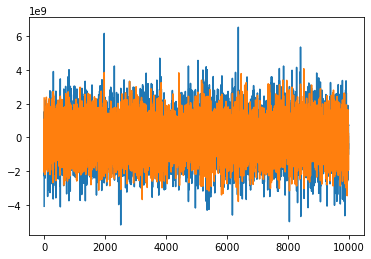

In [ ]:
samples = mcmc.get_samples()["rigidity_scaled"].to_py()
plt.plot(np.diff(samples))
plt.plot(samples)

In [ ]:
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS

def model(height, obs=None, df_em=None):
    sample1 = pyro.sample("rigidity1", dist.Normal(1, 1e-1))

# Run inference in Pyro
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=1, num_chains=1)
mcmc.run(X_train, y_train, df_em)

print(mcmc.get_samples()["rigidity1"].min() , mcmc.get_samples()["rigidity1"].mean(), mcmc.get_samples()["rigidity1"].max())

Sample: 100%|██████████| 1001/1001 [12:24,  1.34it/s, step size=1.16e-10, acc. prob=1.000]

tensor(0.8238) tensor(0.9997) tensor(1.)
